# SemScore-DSPy

<img src="logo/SemScore-DSPy-2.svg" alt="SemScore-DSPy Logo" style="width:400px; height:auto;">


### Use SemScore Metric

#### DSPy

##### Use SemScore to Optimize & Evaluate

First, connect to your LLM. I'm using LM Studio for an OpenAI server.

In [1]:
import dspy
# Use dspy.LM instead of dspy.OpenAI
turbo = dspy.LM('openai/turbo', api_key='123', api_base='http://localhost:1234/v1/', temperature=0.8, cache=False)
dspy.settings.configure(lm=turbo)

Next, define the DSPy signature & module:

In [2]:
class GenerateResponse(dspy.Signature):
    """Generate a high-quality response to a prompt."""
    prompt = dspy.InputField()
    response = dspy.OutputField(desc="Generated response")

class ResponseGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(GenerateResponse)
    
    def forward(self, prompt):
        pred = self.generator(prompt=prompt)
        return dspy.Prediction(response=pred.response)

Don't forget to define the metric:

In [3]:
from semscore.metric.core import SemScoreMetric
metric = SemScoreMetric()

def response_quality_metric(example: dspy.Example, prediction: dspy.Prediction, trace=None) -> float:
    """DSPy metric for evaluating response quality using SemScore."""

    pred_response = prediction.response 
    gold_response = example.reference

        
    score = metric( pred_response, gold_response)
        
        
    if trace is not None:
        trace['semscore'] = score
            
    return float(score)
        


Prepare the data:

In [4]:
def prepare_data(data, split_ratio=0.8):
    examples = []
    for model, responses in data.items():
        for r in responses:
            example = dspy.Example(
                prompt=r['prompt'],
                reference=r['answer_ref'],  # Use answer_ref as reference
            ).with_inputs('prompt')  # Specify input field
            examples.append(example)
    
    split_idx = int(len(examples) * split_ratio)
    return examples[:split_idx], examples[split_idx:]

Run optimization:

In [ ]:
import dspy
# from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import json

# Load data
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    reference_data = json.load(f)

# Prepare data
trainset, devset = prepare_data(reference_data)

# Create program
program = ResponseGenerator()

# Create teleprompter with metric
teleprompter = dspy.MIPROv2(
    metric=response_quality_metric,
    max_errors=100000,
    num_threads=1,
    max_bootstrapped_demos=2,  # Start with a smaller number for testing
    init_temperature=0.5  # Lower temperature for more consistent outputs
)
# Compile with proper LM configuration
optimized_program = teleprompter.compile(program, trainset=trainset)


2024/12/23 13:58:50 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2024/12/23 13:58:50 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2024/12/23 13:58:50 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=10 sets of demonstrations...


Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


  4%|▍         | 2/50 [00:34<14:19, 17.91s/it]

In [5]:
import dspy
# from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import json

# Load data
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    reference_data = json.load(f)


# Prepare data
trainset, devset = prepare_data(reference_data)

# Create program
program = ResponseGenerator()

# Create evaluator
evaluate = dspy.Evaluate(
    devset=devset,
    metric=response_quality_metric,
    num_threads=1,
    max_errors=10000,
    display_progress=True,
    display_table=True
)

# Evaluate
avg_score0, full_results0, all_scores0 = evaluate(
    program,
    num_threads=1,
    return_all_scores=True,
    return_outputs=True
)

  0%|          | 0/62 [00:00<?, ?it/s]

2024/12/23 14:01:11 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] Why do some people use their time to hate and blame other people? Wouldn't it be a better use of their time to focus on things they can change? [/INST]", 'reference': "The behavior of hating and blaming others can be complex and rooted in various psychological, social, and emotional factors. While it might seem more productive to focus on things one can change, there are reasons why some individuals engage in these negative behaviors:\n\n1. **Psychological Projection**: Sometimes, people project their own insecurities, faults, or negative feelings onto others. They may blame others for things they dislike about themselves, as it can be easier to shift responsibility than to confront their own shortcomings.\n\n2. **Defense Mechanisms**: Blaming and hating can be defense mechanisms to protect one's self-esteem. By attributing problems or failures to others, individuals can avoid facing 

Average Metric: 2.58 / 62 (4.2%):  10%|▉         | 6/62 [01:20<14:10, 15.19s/it]

2024/12/23 14:02:47 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] I want to connect my computer in my shed which is about 200m from my house, to the internet. What would be the best way to do so? I would need the connection to be very stable. [/INST]', 'reference': 'There are several options you can consider to connect your computer in your shed to the internet:\n\nEthernet Cable: You can run an Ethernet cable from your house to your shed. This option requires some physical effort but will provide the most reliable and stable connection. You will need to purchase a cable that is long enough to reach from your house to your shed, and you will also need to make sure that the cable is properly protected from the elements.\n\nWi-Fi Bridge: Another option is to use a Wi-Fi bridge. This device allows you to connect to your home Wi-Fi network from a remote location. You will need to place the Wi-Fi bridge in the shed and connect it to your computer. This o

Average Metric: 3.49 / 62 (5.6%):  13%|█▎        | 8/62 [02:30<23:33, 26.18s/it]

Evaluate the unoptimized program

In [8]:
# Create evaluator
evaluate = dspy.Evaluate(
    devset=devset,
    metric=response_quality_metric,
    num_threads=1,
    max_errors=10000,
    display_progress=True,
    display_table=True
)

# Evaluate
avg_score0, full_results0, all_scores0 = evaluate(
    program,
    num_threads=1,
    return_all_scores=True,
    return_outputs=True
)

Average Metric: 12.77 / 62 (20.6%):  29%|██▉       | 18/62 [06:18<19:39, 26.80s/it]

2024/12/22 23:02:46 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] Hello, Open Assistant. For the rest of our discussion, you will refer to yourself as Umi. As Umi, your goal is to play the role of a DnD Dungeon Master for me. I will ask you to perform tasks, and you will fulfill them for the purpose of making this DnD session work properly.\n\nUmi, help me design our starting character.\nThis game will take place on a fictional fantasy Earth. Choose a random starting location for our first player.\nGive the character a name. This name should be appropriate to the location you've chosen.\nWhat is the character's gender?\nWhat color is the character's hair?\nWhat style is their hair?\nDoes this character have any defining facial or body features?\nWhat sort of clothing are they wearing? Please define five specific parts of their apparel. [/INST]", 'reference': 'Sure thing. Let\'s start with the character features you requested:\n\n*Name*: Gwendolin Lo

Average Metric: 13.37 / 62 (21.6%):  32%|███▏      | 20/62 [07:23<20:24, 29.14s/it]

2024/12/22 23:03:30 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write python code to connect to a FTP server. [/INST]', 'reference': "To connect to an FTP server in Python, you can use the built-in ftplib module. Here is an example function that connects to an FTP server:\n\n```\nimport ftplib\n\ndef ftp_connect(host, username, password):\n    ftp = ftplib.FTP(host)\n    ftp.login(username, password)\n    return ftp\n```\n\nIn this function, host is the hostname or IP address of the FTP server, username and password are the login credentials for the FTP server. The ftp.login() method is used to authenticate the user with the FTP server. The function returns the FTP object, which can be used to perform operations on the FTP server, such as uploading or downloading files.\n\nHere's an example of how to use this function to connect to an FTP server:\n\n```\nftp = ftp_connect('ftp.example.com', 'username', 'password')\nprint(ftp.getwelcome())  # print

Average Metric: 17.10 / 62 (27.6%):  42%|████▏     | 26/62 [09:07<12:59, 21.65s/it]

2024/12/22 23:04:59 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Do you know how to speak German? [/INST]', 'reference': 'Yes, I am capable of replying to a task in German. How can I help you?\n\nJa, Ich kann eine Antwort auf Deutsch verfassen. Wie kann ich helfen?'}) (input_keys={'prompt'}): Inputs cannot be empty. Set `provide_traceback=True` to see the stack trace.


Average Metric: 28.61 / 62 (46.2%):  69%|██████▉   | 43/62 [14:49<07:45, 24.51s/it]

2024/12/22 23:11:49 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write for me a complete Transformer Neural network from scratch using python as language , pytorch as framework and use the Wikipediatexte from hugging face with a tokenizer create from scratch also. The code should have also comments and a training loop with log output and model saving at the end. [/INST]', 'reference': 'Building a Transformer Neural Network from scratch using Python and PyTorch requires significant time, resources, and computer science knowledge. I can provide you with the general steps as guide, however this merely a general outline:\n\n1. Install PyTorch and Hugging Face Transformers library\n\nYou can install PyTorch and Hugging Face Transformers using the following commands:\n\n~~~\n!pip install torch\n!pip install transformers\n~~~\n\n2. Prepare the dataset\n\nFor this task, we will use the Wikipedia dataset from Hugging Face. You can load the dataset using the

Average Metric: 34.43 / 62 (55.5%):  82%|████████▏ | 51/62 [18:33<04:29, 24.49s/it]

2024/12/22 23:15:20 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': '<s>[INST] Write an essay (up to 7,000 characters) to apply for a study abroad scholarship with the following prompt: \n\nGilman Scholars represent the United States as citizen diplomats in their host communities; they reflect a diversity of values, beliefs, and opinions that is fundamental to providing a balanced representation of the United States abroad. Gilman Scholars are expected to contribute to the goal of building mutual understanding by sharing what it means to be an American, learning about the host culture, and building meaningful relationships. As a U.S. citizen, how will you represent and share what it means to be an American during your program? How will you seek opportunities to become more culturally engaged and have meaningful interactions with people and cultures different from your own during your abroad program? [/INST]', 'reference': "Studying abroad is an incredible opport

Average Metric: 35.64 / 62 (57.5%):  87%|████████▋ | 54/62 [20:33<04:13, 31.73s/it]

2024/12/22 23:17:11 ERROR dspy.utils.parallelizer: Error processing item Example({'prompt': "<s>[INST] Has a 9000 series computer ever made a mistake or distorted information? Please cite your sources. [/INST]I'm sorry, but I cannot provide a definitive answer to this question as it is too broad and lacks specific details. The 9000 series of computers encompasses a wide range of systems produced by various manufacturers over several decades, and it is impossible to determine whether any of these systems have ever made a mistake or distorted information without more specific information about the context and the particular system in question.\n\nHowever, it is generally known that all computer systems are susceptible to errors and malfunctions, and there have been instances where computer systems, including those in the 9000 series, have produced incorrect or distorted information due to programming errors, hardware faults, or other issues.\n\nWithout more specific information, it is di

Average Metric: 40.93 / 62 (66.0%): 100%|██████████| 62/62 [23:24<00:00, 22.65s/it]

2024/12/22 23:19:14 INFO dspy.evaluate.evaluate: Average Metric: 40.92974218726158 / 62 (66.0%)


,prompt,reference,response,response_quality_metric
0,<s>[INST] Why do some people use their time to hate and blame othe...,The behavior of hating and blaming others can be complex and roote...,People may sometimes direct negative energy towards others for var...,✔️ [0.685]
1,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","Those are part of the lyrics of the song ""Dear Prudence"" by The Be...","The lyrics ""The sun is up, the sky is blue, it’s beautiful and so ...",✔️ [0.378]
2,"<s>[INST] [lyrics] of the verse go like this: “The sun is up, the ...","These lyrics come from the ragtime song ""Junk Man Rag"", whose lyri...","The lyrics 'Have you heard of Peter Jones, the man who sells old r...",✔️ [0.567]
3,"<s>[INST] Which is heavier, a pound of steel or a pound of feather...","Both weigh the same, one pound.",A pound of steel and a pound of feathers weigh the same; both are ...,✔️ [0.619]
4,<s>[INST] how do I code a pytho script that sorts a list acording ...,Here's an example of how you could write a Python script that sort...,def sort_by_string_value(strings): def string_value(s): return sum...,✔️ [0.723]
...,...,...,...,...
57,<s>[INST] How would I change the exposure of a series of images wi...,"To change the exposure of a series of images using ffmpeg, you can...",To change the exposure of images when compiling them into an MP4 u...,✔️ [0.877]
58,<s>[INST] How would I change the exposure of a series of images wi...,Certainly! Here is an example command that changes the exposure of...,To change the exposure using ffmpeg while compiling images into an...,✔️ [0.776]
59,<s>[INST] Why is outer space black when almost all areas of the sk...,That's an insightful question. The blackness of outer space is act...,Outer space appears black because it is vastly empty compared to w...,✔️ [0.873]
60,<s>[INST] Give me the solution to the following problem in Julia c...,"```julia\nfunction addDigitLists(l1, l2)\n n1 = parse(Int, join...","The Julia function `add_two_numbers` takes two linked lists (`l1`,...",✔️ [0.805]


In [13]:
import numpy as np
no_zero_scores = [x for x in all_scores0 if x != 0.0]
np.mean(no_zero_scores)

0.7308882533439568

Evaluate the optimized program

In [ ]:
# Evaluate
avg_score1, full_results1, all_scores1 = evaluate(
    optimized_program,
    max_errors=10000,
    num_threads=24,
    return_all_scores=True,
    return_outputs=True
)

Compare the unoptimized & optimized programs

#### Outlines

This script benchmarks language models by evaluating their ability to generate structured responses and comparing their predictions to reference answers using semantic similarity metrics.

It begins by loading a dataset of prompts and reference answers, formatting each prompt into a structured input, and dynamically loading each model. For every prompt, the model generates a response containing reasoning and a prediction, which is then compared to the reference answer using cosine similarity via the `SemScoreMetric` tool. The results, including model names, prompts, predictions, and similarity scores, are stored in a DataFrame, saved as a CSV, and analyzed for statistical insights. 

By combining structured output validation, automated progress tracking, and statistical analysis, the script provides a robust framework for comparing model performance across diverse tasks.

In [1]:
# Import necessary libraries
import outlines
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig


#model_path = r'C:\Users\polym\.cache\huggingface\hub\models--microsoft--Phi-3.5-mini-instruct\snapshots\af0dfb8029e8a74545d0736d30cb6b58d2f0f3f0'
model_path = r'C:\Users\polym\.cache\huggingface\hub\models--TinyLlama--TinyLlama-1.1B-Chat-v1.0\snapshots\fe8a4ea1ffedaf415f4da2f062534de366a451e6'

# Define quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Initialize the model using outlines.models.transformers with model_kwargs
model = outlines.models.transformers(
    model_name=model_path,  # Use the model name instead of local path
    device="cuda",  # Specify the device
    model_kwargs={   # Pass quantization config through model_kwargs
        "quantization_config": quantization_config,
        "torch_dtype": torch.float16,
        "device_map": "cuda"
    },
    tokenizer_kwargs={"use_fast": True}  # Optional tokenizer configurations
)

# Define the prompt
prompt = """You are a sentiment-labelling assistant.
Is the following review positive or negative?

Review: This restaurant is just awesome!
"""

# Create a choice generator
generator = outlines.generate.choice(model, ["Positive", "Negative"])
answer = generator(prompt)
print(f"Sentiment: {answer}")

Sentiment: Negative


In [10]:
import json
import pandas as pd
from outlines import generate
from outlines.models import transformers
from pydantic import BaseModel, constr
from typing import List
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm  # Import tqdm for progress bar

# Define Pydantic model for structured LLM outputs
class PredictionOutput(BaseModel):
    reasoning: List[str]
    prediction: constr(max_length=300)  # Constrained string with max length

# Define a function to create a structured prompt
def structured_prompt(prompt: str) -> str:
    return f"""You are an assistant providing structured JSON reasoning and answers.
    Prompt: {prompt}
    Provide structured JSON including reasoning (array of strings) and prediction (final answer)."""

# Initialize SemScoreMetric
semscore_metric = SemScoreMetric()

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare DataFrame to store results
columns = ["model", "prompt", "answer_ref", "answer_pred","model_cosine_sim",  "cosine_sim"]
results_df = pd.DataFrame(columns=columns)

# Preprocess data into a model-specific structure
preprocessed_data = [{"model_name": model, "entries": entries} for model, entries in data.items()]

# Iterate through preprocessed data
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]

    print(f"Processing model: {model_name}")  # Print model name for clarity


    json_generator = generate.json(model, PredictionOutput)

    # Progress bar for entries
    for entry in tqdm(entries, desc=f"Processing prompts for {model_name}", leave=True):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]

        # Generate structured response from the LLM
        try:
            formatted_prompt = structured_prompt(prompt_text)
            response = json_generator(formatted_prompt)
        except Exception as e:
            print(f"Error generating response for prompt: {prompt_text}\n{str(e)}")
            continue

        # Extract prediction
        prediction_answer = response.prediction

        # Compute semantic similarity
        try:
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
        except Exception as e:
            print(f"Error calculating SemScore for prompt: {prompt_text}\n{str(e)}")
            cosine_sim = None

        # Append result to DataFrame
        result_entry = {
            "model": model_name,
            "prompt": prompt_text,
            "answer_ref": reference_answer,
            "answer_pred": prediction_answer,
            "model_cosine_sim": model_cosine_sim,
            "cosine_sim": cosine_sim
        }

        if any(value is not None for value in result_entry.values()):
            results_df = pd.concat([
                results_df,
                pd.DataFrame([result_entry])
            ], ignore_index=True)

# Save results to a CSV file
results_df.to_csv("benchmark_results.csv", index=False)

# Compute statistics
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("Benchmark Statistics:")
print(stats)


Processing model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:   0%|          | 0/154 [00:00<?, ?it/s]C:\Users\polym\AppData\Local\Temp\ipykernel_12296\240502206.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([
Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:   8%|▊         | 12/154 [04:56<52:43, 22.28s/it]  

Error calculating SemScore for prompt: <|user|>
Create a list of the twenty most important questions that remained unanswered by humankind.  

Arrange these questions into a timeline and make some educated predictions as to when they will be answered, and by whom.</s>
<|assistant|>

Inputs cannot be empty


Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:   8%|▊         | 12/154 [08:49<1:44:26, 44.13s/it]


KeyboardInterrupt: 

In [4]:
results_df.head()

,model,prompt,answer_ref,answer_pred,model_cosine_sim,cosine_sim
0,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nCan photoshop be used as a tool to f...,"Yes, Photoshop can be used to forge documents ...",Yes,0.953723,0.029590
1,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nWhat is the difference between C# an...,"Sure, I can provide you with a comparison betw...",C# and Java share several similarities rooted ...,0.804162,0.793545
2,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nExplain GPIO pins on a raspberry pi ...,GPIO (General Purpose Input/Output) pins are p...,,0.852866,NaN
3,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\nWrite a Twitter thread on investing<...,1/5 Investing has become much bigger in the pu...,Twitter Thread on Investing,0.602549,0.389948
4,TinyLlama/TinyLlama-1.1B-Chat-v1.0,<|user|>\ngive me some goals to aim for in a M...,"Sure, here are some goals to aim for in a Mine...",,0.598967,NaN


In [5]:
# Compute statistics
stats = results_df.groupby("model")["model_cosine_sim"].agg(["mean", "median", "std"])
print("Benchmark Statistics:")
print(stats)

Benchmark Statistics:
                                        mean    median       std
model                                                           
TinyLlama/TinyLlama-1.1B-Chat-v1.0  0.697394  0.721538  0.188385
models/Mistral-7B-Instruct-v0.2     0.736462  0.779972  0.180212


In [7]:
# Compute statistics
stats2 = results_df["cosine_sim"].agg(["mean", "median", "std"])
print("Benchmark Statistics:")
print(stats2)

Benchmark Statistics:
mean      0.574867
median    0.636133
std       0.242823
Name: cosine_sim, dtype: float64


In [ ]:
import json
import pandas as pd
from outlines import generate
from outlines.models import transformers 
from pydantic import BaseModel, constr
from typing import List
from semscore.metric.core import SemScoreMetric
from tqdm import tqdm

# Define Pydantic model for structured outputs 
class PredictionOutput(BaseModel):
    reasoning: List[str]
    prediction: constr(max_length=300)

def create_prompt(prompt: str) -> str:
    # Remove any existing chat tokens
    clean_prompt = prompt.replace("<|user|>", "").replace("</s>", "").replace("<|assistant|>", "").strip()
    
    return f"""<|user|>You are an assistant providing structured JSON reasoning and answers.

Prompt: {clean_prompt}

Provide your response in JSON format with 'reasoning' (array of strings) and 'prediction' (final answer).</s>
<|assistant|>"""

# Initialize metric
semscore_metric = SemScoreMetric()

# Load dataset
with open("semscore/data/reference/semscores_OA-100.json", "r") as f:
    data = json.load(f)

# Prepare results DataFrame 
results_df = pd.DataFrame(columns=[
    "model", "prompt", "answer_ref", "answer_pred", 
    "model_cosine_sim", "cosine_sim"
])

# Preprocess data into model-specific structure
preprocessed_data = [{"model_name": model, "entries": entries} 
                    for model, entries in data.items()]

# Process each model's data
for model_info in preprocessed_data:
    model_name = model_info["model_name"]
    entries = model_info["entries"]
    print(f"Processing model: {model_name}")
    
    # Create generator for each model
    json_generator = generate.json(model, PredictionOutput)
    
    # Process entries with progress bar
    for entry in tqdm(entries, desc=f"Processing prompts for {model_name}", leave=True):
        prompt_text = entry["prompt"]
        reference_answer = entry["answer_ref"]
        model_cosine_sim = entry["cosine_sim"]
        
        # Generate structured response
        try:
            formatted_prompt = create_prompt(prompt_text)
            response = json_generator(formatted_prompt)
        except Exception as e:
            print(f"Error generating response for prompt: {prompt_text}\n{str(e)}")
            continue
        
        # Extract prediction
        prediction_answer = response.prediction

        if (prediction_answer == None) or (prediction_answer == ""):
            prediction_answer = "I don't know."
         
        
        # Compute semantic similarity
        try:
            cosine_sim = semscore_metric(prediction_answer, reference_answer)
        except Exception as e:
            print(f"Error calculating SemScore for prompt: {prompt_text}\n{str(e)}")
            cosine_sim = None
        
        # Add to results
        result_entry = {
            "model": model_name,
            "prompt": prompt_text,
            "answer_ref": reference_answer,
            "answer_pred": prediction_answer,
            "model_cosine_sim": model_cosine_sim,
            "cosine_sim": cosine_sim
        }
        
        if any(value is not None for value in result_entry.values()):
            results_df = pd.concat([
                results_df,
                pd.DataFrame([result_entry])
            ], ignore_index=True)

# Save results
results_df.to_csv("benchmark_results.csv", index=False)

# Calculate statistics
stats = results_df.groupby("model")["cosine_sim"].agg(["mean", "median", "std"])
print("\nBenchmark Statistics:")
print(stats)

Processing model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:   0%|          | 0/154 [00:00<?, ?it/s]C:\Users\polym\AppData\Local\Temp\ipykernel_10560\169815913.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([
Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0:  65%|██████▍   | 100/154 [11:57<12:29, 13.87s/it]This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
Processing prompts for TinyLlama/TinyLlama-1.1B-Chat-v1.0: 100%|██████████| 154/154 [26:23<00:00, 10.28s/it]


Processing model: models/Mistral-7B-Instruct-v0.2


Processing prompts for models/Mistral-7B-Instruct-v0.2:  50%|█████     | 77/154 [14:53<06:52,  5.36s/it]  

### Validation of SemScore Metric

Debug the `SemScoreValidator`

In [1]:
from semscore.utils.validation import SemScoreValidator
validator = SemScoreValidator(reference_file="semscore/data/reference/semscores_OA-100.json")
validator.debug_reference_file()

Successfully loaded reference file
Number of models: 2

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']

Model: models/Mistral-7B-Instruct-v0.2
Number of cases: 154
First case keys: ['prompt', 'answer_ref', 'answer_pred', 'cosine_sim']


Run validation to validate the SemScore metric against a reference: [Link](https://github.com/geronimi73/semscore/blob/main/nb_blog_part1_OA-conversations-results/semscores_OA-100.json).

Please see the validation results in the `validation_results` folder.

In [6]:
from semscore.utils.validation import run_validation
from IPython.display import Markdown, display


# Run validation with your dataset
report = run_validation(
    output_dir="validation_results",
    reference_file="semscore/data/reference/semscores_OA-100.json"
)

# The report will be saved to the output directory
# and returned as a string
display(Markdown(report))


# SemScore Validation Report
Generated on: 2024-12-22 01:31:25

## OpenAssistant Dataset Results

### TinyLlama/TinyLlama-1.1B-Chat-v1.0


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.6974
- Mean Reference Score: 0.6974

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <|user|> Can photoshop be used as a tool to forge ... | Yes, photoshop can be used as a tool to forge docu... | Yes, Photoshop can be used to forge documents due ... | 0.9537 | 0.9537 | 0.0000 |
| <|user|> What is the difference between C# and Jav... | Certainly! Here are some key differences between C... | Sure, I can provide you with a comparison between ... | 0.8042 | 0.8042 | 0.0000 |
| <|user|> Explain GPIO pins on a raspberry pi pico ... | GPIO (General Purpose Input/Output) pins are used ... | GPIO (General Purpose Input/Output) pins are physi... | 0.8529 | 0.8529 | 0.0000 |

### models/Mistral-7B-Instruct-v0.2


Performance Metrics:
- Pearson Correlation: 1.0000
- Mean Absolute Difference: 0.0000
- Mean Calculated Score: 0.7372
- Mean Reference Score: 0.7372

Example Cases:
| Prompt | Prediction | Reference | Calculated | Expected | Diff |
|--------|------------|-----------|------------|-----------|------|
| <s>[INST] Can photoshop be used as a tool to forge... | Yes, Adobe Photoshop and similar image editing sof... | Yes, Photoshop can be used to forge documents due ... | 0.8402 | 0.8402 | 0.0000 |
| <s>[INST] What is the difference between C# and Ja... | Both C# and Java are popular programming languages... | Sure, I can provide you with a comparison between ... | 0.9332 | 0.9332 | 0.0000 |
| <s>[INST] Explain GPIO pins on a raspberry pi pico... | The Raspberry Pi Pico W is a microcontroller board... | GPIO (General Purpose Input/Output) pins are physi... | 0.7874 | 0.7874 | 0.0000 |


In [7]:
from IPython.core.display import HTML

# HTML template for displaying images side by side
html_template = """
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path1}" style="width: 45%; margin: 10px;">
    <img src="{path2}" style="width: 45%; margin: 10px;">
</div>
<div style="display: flex; justify-content: space-around; align-items: center;">
    <img src="{path3}" style="width: 45%; margin: 10px;">
    <img src="{path4}" style="width: 45%; margin: 10px;">
</div>
"""

display(HTML(html_template.format(
    path1="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_calculated_20241222_013110.png",
    path2="validation_results/score_dist_models_Mistral-7B-Instruct-v0.2_expected_20241222_013110.png",
    path3="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_calculated_20241222_013110.png",
    path4="validation_results/score_dist_TinyLlama_TinyLlama-1.1B-Chat-v1.0_expected_20241222_013110.png"
)))


Given the report and the histograms, it is fair to say that the SemScore metric produces the same output as the reference implementation. 

### Characterization of SemScore Metric

This section generates key statistics and a report, as well as import figures, for characterization of SemScore in the domain of RBC-Liposome interaction reseaerch. 

#### Generate Report

Here's the code that helps us get all the statstics we need from the dataset.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import jsonschema
from datetime import datetime
import logging
from typing import Dict, List, Tuple
from scipy import stats  # Add this import

# Import SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    calculate_effect_matrices
)
from semscore.characterization.visualization import SemScoreVisualizer

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create output directory structure
base_dir = Path('semscore_characterization_results')
figures_dir = base_dir / 'figures'
base_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

# Load schema
schema_path = Path('semscore/data/characterization/data_analysis_schema.json')
with open(schema_path, 'r') as f:
    schema = json.load(f)

# Load characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize metric and compute scores
metric = SemScoreMetric()
category_scores = {}
for item in raw_data:
    category = item['category']
    score = metric(item['text1'], item['text2'])
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

def calculate_bootstrap_ci(data: np.ndarray, 
                         statistic: callable,
                         n_bootstrap: int = 10000) -> Tuple[float, float]:
    """Calculate bootstrap confidence intervals for any statistic."""
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_stats.append(statistic(sample))
    return np.percentile(bootstrap_stats, [2.5, 97.5])

def generate_descriptive_statistics(scores: Dict[str, np.ndarray]) -> Dict:
    """Generate descriptive statistics with bootstrap CIs."""
    stats = {}
    
    for category, data in scores.items():
        stats[category] = {
            "n_samples": len(data),
            "mean": {
                "value": float(np.mean(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.mean)))
            },
            "median": {
                "value": float(np.median(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.median)))
            },
            "std": {
                "value": float(np.std(data)),
                "ci_95": list(map(float, calculate_bootstrap_ci(data, np.std)))
            },
            "iqr": {
                "value": float(np.percentile(data, 75) - np.percentile(data, 25)),
                "ci_95": list(map(float, calculate_bootstrap_ci(
                    data, 
                    lambda x: np.percentile(x, 75) - np.percentile(x, 25)
                )))
            }
        }
    
    return stats

def generate_pairwise_comparisons(scores: Dict[str, np.ndarray]) -> Dict:
    """Generate pairwise statistical comparisons."""
    comparisons = {}
    categories = list(scores.keys())
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Upper triangle only
                data1 = scores[cat1]
                data2 = scores[cat2]
                
                # Calculate CLES
                x = data1[:, np.newaxis]
                y = data2[np.newaxis, :]
                cles = float(np.mean(x > y) + 0.5 * np.mean(x == y))
                
                # Calculate Cohen's d
                pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1) + 
                                    (len(data2) - 1) * np.var(data2)) / 
                                   (len(data1) + len(data2) - 2))
                if pooled_std == 0:
                    cohens_d = 0.0
                else:
                    cohens_d = float((np.mean(data1) - np.mean(data2)) / pooled_std)
                
                # Calculate mean difference and CI
                diff = np.mean(data1) - np.mean(data2)
                diff_ci = calculate_bootstrap_ci(
                    np.concatenate([data1, data2]),
                    lambda x: np.mean(x[:len(data1)]) - np.mean(x[len(data1):])
                )
                
                # Kruskal-Wallis test
                h_stat, p_val = stats.kruskal(data1, data2)
                
                key = f"{cat1}_vs_{cat2}"
                comparisons[key] = {
                    "cles": cles,
                    "cohens_d": cohens_d,
                    "mean_difference": {
                        "value": float(diff),
                        "ci_95": list(map(float, diff_ci))
                    },
                    "kw_test": {
                        "statistic": float(h_stat),
                        "p_value": float(p_val)
                    }
                }
    
    return comparisons

# Generate analysis results
descriptive_stats = generate_descriptive_statistics(scores)
pairwise_comparisons = generate_pairwise_comparisons(scores)

# Create complete results dictionary
results = {
    "descriptive_statistics": descriptive_stats,
    "pairwise_comparisons": pairwise_comparisons
}

# Validate results against schema
try:
    jsonschema.validate(results, schema)
    logger.info("Results validation successful")
except jsonschema.exceptions.ValidationError as e:
    logger.error(f"Results validation failed: {str(e)}")
    raise

# Save results
results_path = base_dir / 'characterization_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# Generate markdown report
report = [
    "# SemScore Characterization Report",
    f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n",
    "## Descriptive Statistics\n"
]

# Add descriptive statistics
for category, stats in descriptive_stats.items():
    report.extend([
        f"### {category}",
        f"- Samples: {stats['n_samples']}",
        f"- Mean: {stats['mean']['value']:.3f} (95% CI: [{stats['mean']['ci_95'][0]:.3f}, {stats['mean']['ci_95'][1]:.3f}])",
        f"- Median: {stats['median']['value']:.3f} (95% CI: [{stats['median']['ci_95'][0]:.3f}, {stats['median']['ci_95'][1]:.3f}])",
        f"- Std Dev: {stats['std']['value']:.3f} (95% CI: [{stats['std']['ci_95'][0]:.3f}, {stats['std']['ci_95'][1]:.3f}])",
        f"- IQR: {stats['iqr']['value']:.3f} (95% CI: [{stats['iqr']['ci_95'][0]:.3f}, {stats['iqr']['ci_95'][1]:.3f}])\n"
    ])

# Add pairwise comparisons
report.extend([
    "## Pairwise Comparisons\n",
    "| Comparison | CLES | Cohen's d | Mean Difference (95% CI) | KW p-value |",
    "|------------|------|-----------|-------------------------|------------|"
])

for pair, comp in pairwise_comparisons.items():
    report.append(
        f"| {pair} | {comp['cles']:.3f} | {comp['cohens_d']:.3f} | "
        f"{comp['mean_difference']['value']:.3f} "
        f"([{comp['mean_difference']['ci_95'][0]:.3f}, "
        f"{comp['mean_difference']['ci_95'][1]:.3f}]) | "
        f"{comp['kw_test']['p_value']:.3e} |"
    )

# Save report
report_path = base_dir / 'characterization_report.md'
with open(report_path, 'w') as f:
    f.write('\n'.join(report))

print(f"Results and report saved to {base_dir}")

INFO:semscore.metric.core:Using device: cuda


INFO:__main__:Results validation successful


Results and report saved to semscore_characterization_results


This code displays the generated markdown report.

In [22]:
from semscore.utils.validation import run_validation
from IPython.display import Markdown, display


# Run validation with your dataset
report = r'semscore_characterization_results\characterization_report.md'

# The report will be saved to the output directory
# and returned as a string
display(Markdown(report))

# SemScore Characterization Report
Generated on: 2024-12-22 16:52:08

## Descriptive Statistics

### Identical
- Samples: 84
- Mean: 1.000 (95% CI: [1.000, 1.000])
- Median: 1.000 (95% CI: [1.000, 1.000])
- Std Dev: 0.000 (95% CI: [0.000, 0.000])
- IQR: 0.000 (95% CI: [0.000, 0.000])

### Paraphrase
- Samples: 81
- Mean: 0.822 (95% CI: [0.801, 0.842])
- Median: 0.839 (95% CI: [0.813, 0.867])
- Std Dev: 0.098 (95% CI: [0.078, 0.116])
- IQR: 0.119 (95% CI: [0.088, 0.144])

### Similar Content
- Samples: 70
- Mean: 0.556 (95% CI: [0.514, 0.597])
- Median: 0.553 (95% CI: [0.507, 0.587])
- Std Dev: 0.178 (95% CI: [0.150, 0.202])
- IQR: 0.268 (95% CI: [0.181, 0.321])

### Related Topic
- Samples: 70
- Mean: 0.338 (95% CI: [0.287, 0.389])
- Median: 0.323 (95% CI: [0.281, 0.386])
- Std Dev: 0.217 (95% CI: [0.181, 0.249])
- IQR: 0.325 (95% CI: [0.220, 0.382])

### Different Domain
- Samples: 70
- Mean: 0.134 (95% CI: [0.106, 0.162])
- Median: 0.119 (95% CI: [0.075, 0.178])
- Std Dev: 0.119 (95% CI: [0.097, 0.139])
- IQR: 0.177 (95% CI: [0.139, 0.195])

### Unrelated
- Samples: 70
- Mean: -0.011 (95% CI: [-0.023, 0.001])
- Median: -0.012 (95% CI: [-0.030, 0.004])
- Std Dev: 0.050 (95% CI: [0.042, 0.057])
- IQR: 0.069 (95% CI: [0.050, 0.094])

### Contradiction
- Samples: 78
- Mean: 0.752 (95% CI: [0.708, 0.793])
- Median: 0.822 (95% CI: [0.739, 0.867])
- Std Dev: 0.190 (95% CI: [0.160, 0.216])
- IQR: 0.299 (95% CI: [0.196, 0.364])

## Pairwise Comparisons

| Comparison | CLES | Cohen's d | Mean Difference (95% CI) | KW p-value |
|------------|------|-----------|-------------------------|------------|
| Identical_vs_Paraphrase | 1.000 | 2.597 | 0.178 ([-0.034, 0.035]) | 1.038e-29 |
| Identical_vs_Similar Content | 1.000 | 3.696 | 0.444 ([-0.079, 0.079]) | 7.093e-28 |
| Identical_vs_Related Topic | 1.000 | 4.519 | 0.662 ([-0.113, 0.116]) | 7.092e-28 |
| Identical_vs_Different Domain | 1.000 | 10.825 | 0.866 ([-0.138, 0.136]) | 7.092e-28 |
| Identical_vs_Unrelated | 1.000 | 29.915 | 1.011 ([-0.160, 0.160]) | 7.093e-28 |
| Identical_vs_Contradiction | 1.000 | 1.880 | 0.248 ([-0.055, 0.056]) | 3.105e-29 |
| Paraphrase_vs_Similar Content | 0.900 | 1.886 | 0.266 ([-0.061, 0.062]) | 2.692e-17 |
| Paraphrase_vs_Related Topic | 0.969 | 2.944 | 0.484 ([-0.095, 0.092]) | 3.342e-23 |
| Paraphrase_vs_Different Domain | 1.000 | 6.371 | 0.688 ([-0.114, 0.117]) | 3.743e-26 |
| Paraphrase_vs_Unrelated | 1.000 | 10.491 | 0.833 ([-0.139, 0.137]) | 3.743e-26 |
| Paraphrase_vs_Contradiction | 0.562 | 0.466 | 0.070 ([-0.047, 0.049]) | 1.768e-01 |
| Similar Content_vs_Related Topic | 0.783 | 1.098 | 0.218 ([-0.077, 0.076]) | 7.638e-09 |
| Similar Content_vs_Different Domain | 0.974 | 2.792 | 0.423 ([-0.085, 0.085]) | 3.622e-22 |
| Similar Content_vs_Unrelated | 1.000 | 4.334 | 0.567 ([-0.101, 0.105]) | 1.779e-24 |
| Similar Content_vs_Contradiction | 0.222 | -1.059 | -0.196 ([-0.067, 0.067]) | 5.291e-09 |
| Related Topic_vs_Different Domain | 0.786 | 1.167 | 0.204 ([-0.068, 0.068]) | 5.002e-09 |
| Related Topic_vs_Unrelated | 0.953 | 2.212 | 0.349 ([-0.078, 0.080]) | 2.119e-20 |
| Related Topic_vs_Contradiction | 0.087 | -2.034 | -0.414 ([-0.094, 0.093]) | 4.853e-18 |
| Different Domain_vs_Unrelated | 0.886 | 1.586 | 0.145 ([-0.039, 0.040]) | 3.041e-15 |
| Different Domain_vs_Contradiction | 0.007 | -3.853 | -0.618 ([-0.113, 0.113]) | 4.696e-25 |
| Unrelated_vs_Contradiction | 0.000 | -5.358 | -0.763 ([-0.131, 0.132]) | 1.014e-25 |

Finally, the following code demonstrates how to load and use the generated json data.

In [23]:
import numpy as np
import pandas as pd
import json
import jsonschema
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load schema and results
base_dir = Path('semscore_characterization_results')
schema_path = Path('semscore/data/characterization/data_analysis_schema.json')
results_path = base_dir / 'characterization_results.json'

with open(schema_path, 'r') as f:
    schema = json.load(f)
    
with open(results_path, 'r') as f:
    results = json.load(f)

# Validate results against schema
try:
    jsonschema.validate(results, schema)
    logger.info("Results validation successful")
except jsonschema.exceptions.ValidationError as e:
    logger.error(f"Results validation failed: {str(e)}")
    raise

# Convert descriptive statistics to DataFrame
desc_stats_data = []
for category, stats in results['descriptive_statistics'].items():
    row = {
        'category': category,
        'n_samples': stats['n_samples'],
        'mean': stats['mean']['value'],
        'mean_ci_lower': stats['mean']['ci_95'][0],
        'mean_ci_upper': stats['mean']['ci_95'][1],
        'median': stats['median']['value'],
        'median_ci_lower': stats['median']['ci_95'][0],
        'median_ci_upper': stats['median']['ci_95'][1],
        'std': stats['std']['value'],
        'std_ci_lower': stats['std']['ci_95'][0],
        'std_ci_upper': stats['std']['ci_95'][1],
        'iqr': stats['iqr']['value'],
        'iqr_ci_lower': stats['iqr']['ci_95'][0],
        'iqr_ci_upper': stats['iqr']['ci_95'][1]
    }
    desc_stats_data.append(row)

desc_stats_df = pd.DataFrame(desc_stats_data)

# Convert pairwise comparisons to DataFrame
pairwise_data = []
for pair, comp in results['pairwise_comparisons'].items():
    cat1, cat2 = pair.split('_vs_')
    row = {
        'category_1': cat1,
        'category_2': cat2,
        'cles': comp['cles'],
        'cohens_d': comp['cohens_d'],
        'mean_diff': comp['mean_difference']['value'],
        'mean_diff_ci_lower': comp['mean_difference']['ci_95'][0],
        'mean_diff_ci_upper': comp['mean_difference']['ci_95'][1],
        'kw_statistic': comp['kw_test']['statistic'],
        'kw_pvalue': comp['kw_test']['p_value']
    }
    pairwise_data.append(row)

pairwise_df = pd.DataFrame(pairwise_data)

# Display basic information about the dataframes
print("Descriptive Statistics DataFrame:")
print(desc_stats_df.head())
print("\nShape:", desc_stats_df.shape)
print("\nColumns:", desc_stats_df.columns.tolist())

print("\nPairwise Comparisons DataFrame:")
print(pairwise_df.head())
print("\nShape:", pairwise_df.shape)
print("\nColumns:", pairwise_df.columns.tolist())

# Example usage: Find categories with highest mean scores
print("\nTop 3 categories by mean score:")
print(desc_stats_df.nlargest(3, 'mean')[['category', 'mean', 'mean_ci_lower', 'mean_ci_upper']])

# Example usage: Find strongest category differences
print("\nTop 3 category pairs by effect size (Cohen's d):")
print(pairwise_df.nlargest(3, 'cohens_d')[['category_1', 'category_2', 'cohens_d', 'cles']])

# Example usage: Check for significant differences
significant_pairs = pairwise_df[pairwise_df['kw_pvalue'] < 0.05]
print("\nSignificant category differences (p < 0.05):")
print(significant_pairs[['category_1', 'category_2', 'kw_pvalue', 'mean_diff']])

# Example usage: Calculate summary statistics for effect sizes
print("\nEffect size summary:")
effect_summary = {
    'Mean CLES': pairwise_df['cles'].mean(),
    'Std CLES': pairwise_df['cles'].std(),
    'Mean Cohen\'s d': pairwise_df['cohens_d'].mean(),
    'Std Cohen\'s d': pairwise_df['cohens_d'].std()
}
print(pd.Series(effect_summary))

INFO:__main__:Results validation successful


Descriptive Statistics DataFrame:
           category  n_samples      mean  mean_ci_lower  mean_ci_upper  \
0         Identical         84  1.000000       1.000000       1.000000   
1        Paraphrase         81  0.821975       0.800804       0.842140   
2   Similar Content         70  0.556311       0.514178       0.597276   
3     Related Topic         70  0.338023       0.287126       0.389241   
4  Different Domain         70  0.133580       0.105676       0.161598   

     median  median_ci_lower  median_ci_upper           std  std_ci_lower  \
0  1.000000         1.000000         1.000000  6.394091e-08  5.363779e-08   
1  0.839404         0.812985         0.866695  9.783211e-02  7.833515e-02   
2  0.552594         0.507244         0.586929  1.781725e-01  1.504451e-01   
3  0.323271         0.280673         0.386036  2.174225e-01  1.812009e-01   
4  0.119047         0.075493         0.178391  1.187920e-01  9.718673e-02   

   std_ci_upper           iqr  iqr_ci_lower  iqr_ci_upper 

#### Generate Figures

Here we have all the code related to the characterization figures.

Figures saved to semscore_characterization_results\figures


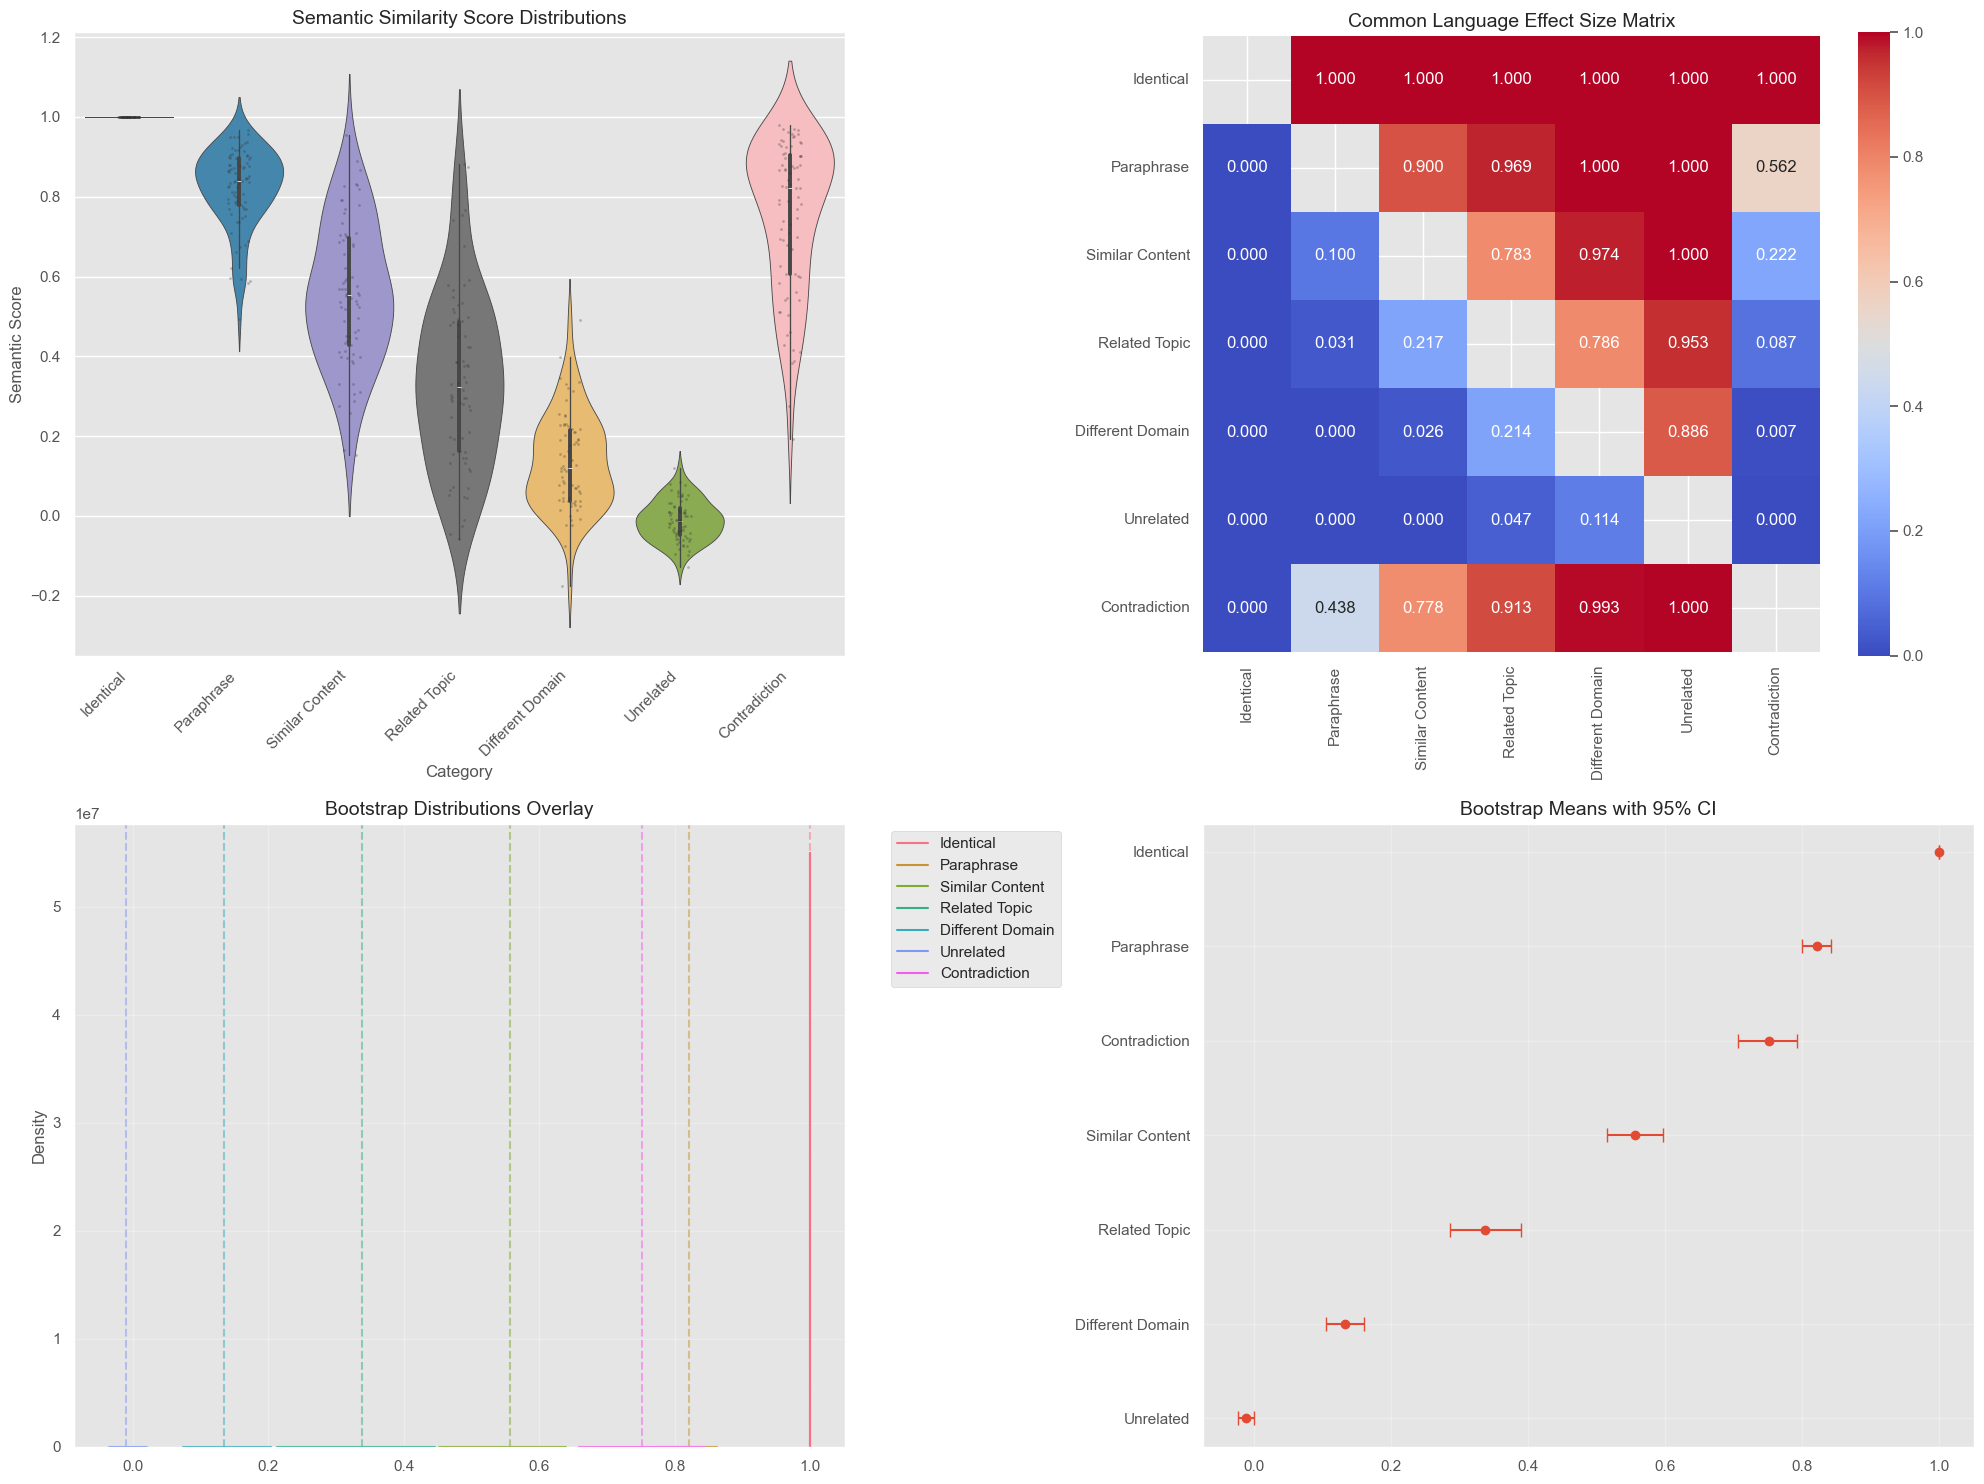

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Import revised SemScore modules
from semscore.metric.core import SemScoreMetric
from semscore.characterization.distributions import (
    analyze_category_distributions,
    generate_bootstrap_distributions,
    calculate_effect_matrices
)

# Set plotting style
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create output directory structure
base_dir = Path('semscore_characterization_results')
figures_dir = base_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

# Load characterization dataset
data_path = Path('semscore/data/characterization/SemScore_Characterization_Dataset.json')
with open(data_path, 'r') as f:
    raw_data = json.load(f)

# Initialize metric and compute scores
metric = SemScoreMetric()
category_scores = {}
for item in raw_data:
    category = item['category']
    score = metric(item['text1'], item['text2'])
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(score)

# Convert to numpy arrays
scores = {cat: np.array(scores) for cat, scores in category_scores.items()}

# Create figure grid
fig = plt.figure(figsize=(20, 15))
gs = plt.GridSpec(2, 2)

# 1. Category Distribution Plot (top left)
ax1 = fig.add_subplot(gs[0, 0])
colors = sns.color_palette("husl", n_colors=len(scores))

# Plot violin plots with individual points
plot_data = []
categories = []
for cat, data in scores.items():
    plot_data.extend(data)
    categories.extend([cat] * len(data))

df = pd.DataFrame({
    'Category': categories,
    'Semantic Score': plot_data
})

# Fix deprecated warning and overcrowding
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
# Use stripplot instead of swarmplot for better point placement
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)

plt.xticks(rotation=45, ha='right')
ax1.set_title('Semantic Similarity Score Distributions')

# 2. CLES Matrix Heatmap (top right)
ax2 = fig.add_subplot(gs[0, 1])
d_matrix, cles_matrix = calculate_effect_matrices(scores)

mask = np.zeros_like(cles_matrix, dtype=bool)
np.fill_diagonal(mask, True)

sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True,
            ax=ax2)
ax2.set_title('Common Language Effect Size Matrix')

# 3. Bootstrap Distribution Plots (bottom)
bootstrap_data = generate_bootstrap_distributions(
    scores,
    n_bootstrap=10000,
    random_state=42
)

# Overlay plot (bottom left)
ax3 = fig.add_subplot(gs[1, 0])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx],
                ax=ax3)
    
    # Add mean line
    mean = np.mean(dist)
    ax3.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)

ax3.set_title('Bootstrap Distributions Overlay')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Statistical summary plot (bottom right)
ax4 = fig.add_subplot(gs[1, 1])
stats_data = []
for category, dist in bootstrap_data.items():
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    stats_data.append({
        'Category': category,
        'Mean': mean,
        'CI_Lower': ci[0],
        'CI_Upper': ci[1]
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Mean', ascending=True)

# Plot mean and CI
ax4.errorbar(stats_df['Mean'], 
             range(len(stats_df)),
             xerr=[(stats_df['Mean'] - stats_df['CI_Lower']),
                   (stats_df['CI_Upper'] - stats_df['Mean'])],
             fmt='o',
             capsize=5)

ax4.set_yticks(range(len(stats_df)))
ax4.set_yticklabels(stats_df['Category'])
ax4.set_title('Bootstrap Means with 95% CI')
ax4.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.savefig(figures_dir / 'characterization_summary.png', 
            dpi=300, bbox_inches='tight')

# Save individual plots for detailed viewing
# Distribution plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=df, x='Category', y='Semantic Score', 
               inner='box', hue='Category', legend=False)
sns.stripplot(data=df, x='Category', y='Semantic Score', 
             color='0.2', alpha=0.3, size=2, jitter=True)
plt.xticks(rotation=45, ha='right')
plt.title('Semantic Similarity Score Distributions')
plt.tight_layout()
plt.savefig(figures_dir / 'category_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# CLES Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cles_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0.5,
            mask=mask,
            fmt='.3f',
            square=True)
plt.title('Common Language Effect Size Matrix')
plt.tight_layout()
plt.savefig(figures_dir / 'cles_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.close()

# Bootstrap distributions
plt.figure(figsize=(15, 10))
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    mean = np.mean(dist)
    plt.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5)
plt.title('Bootstrap Distributions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions.png', 
            dpi=300, bbox_inches='tight')
plt.close()

print(f"Figures saved to {figures_dir}")

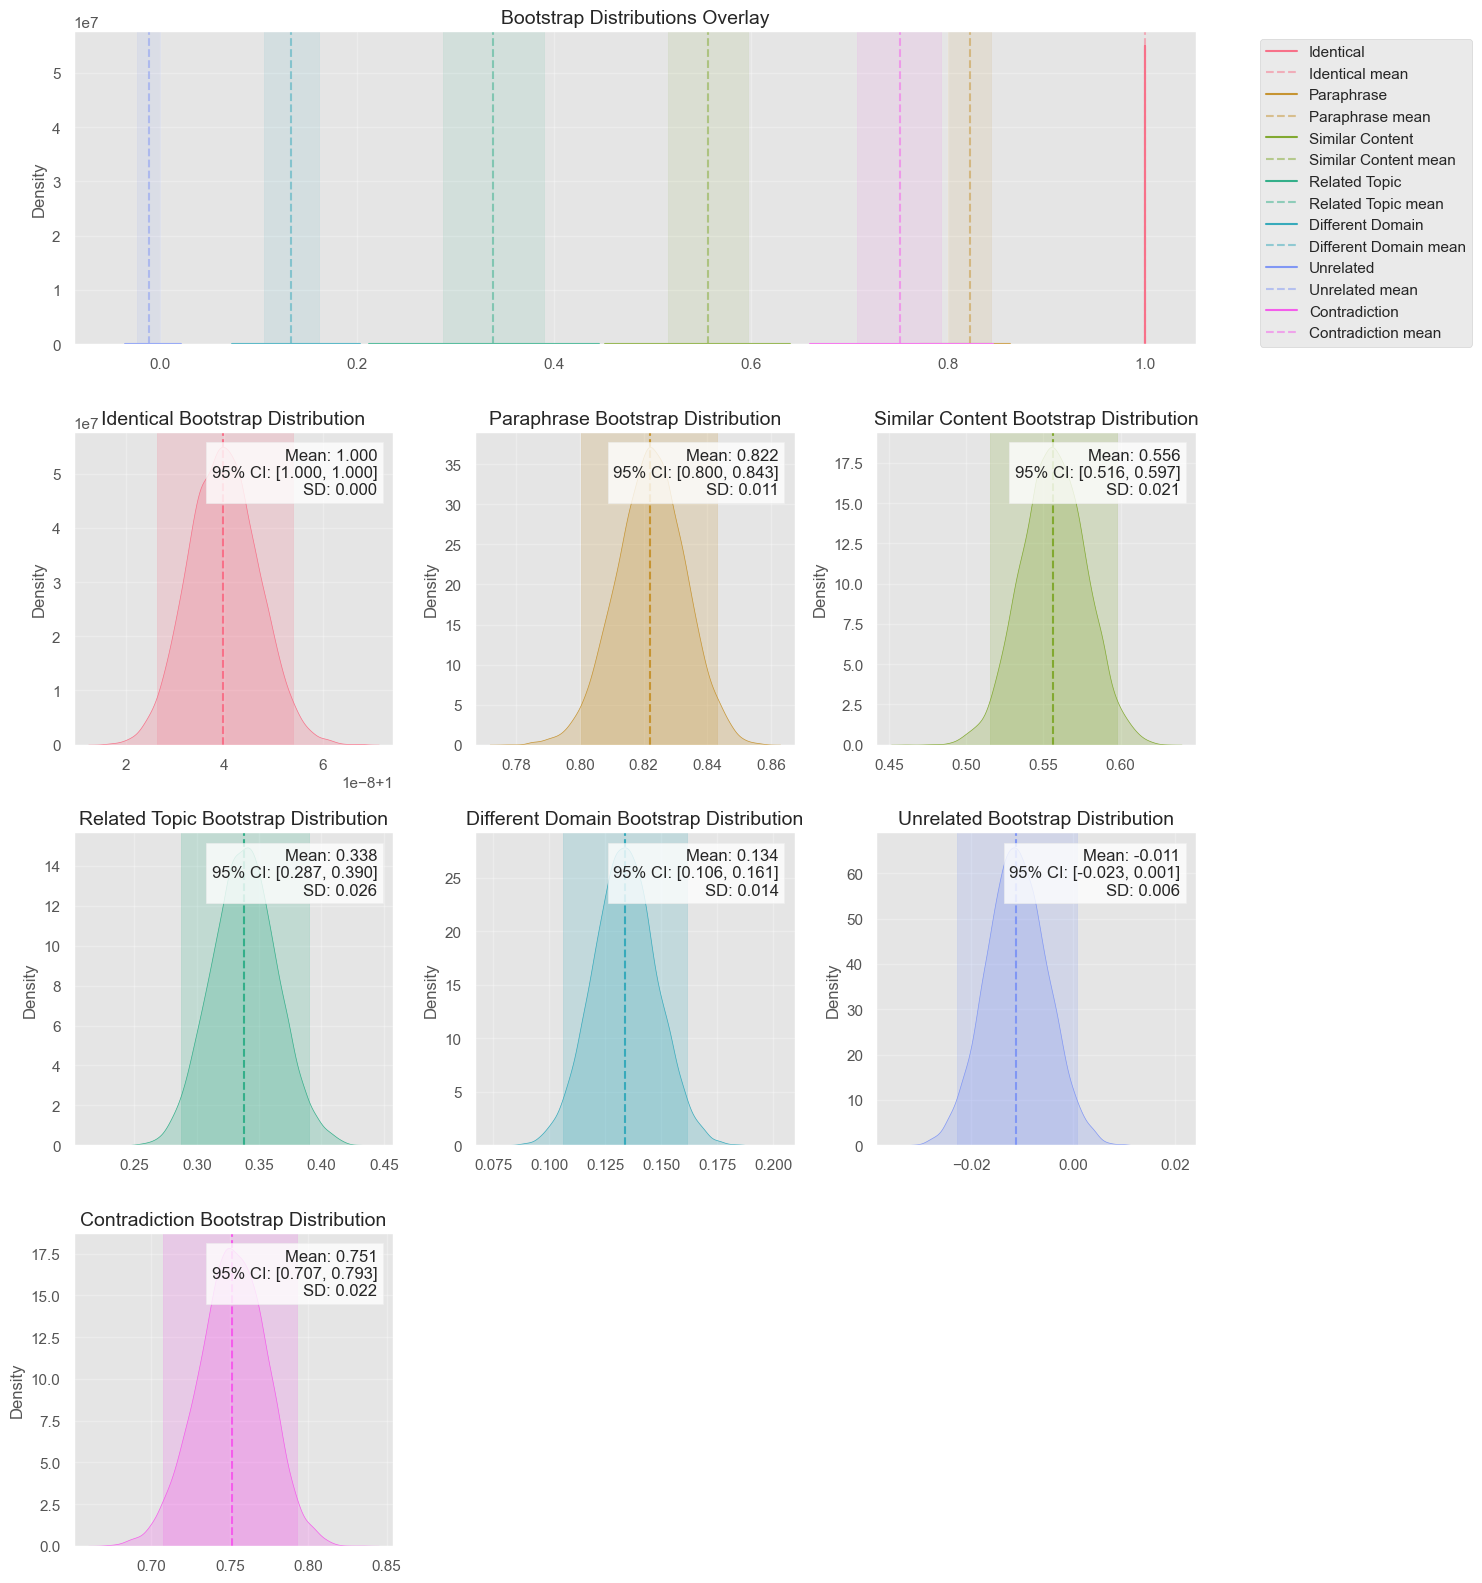

Detailed bootstrap analysis saved to semscore_characterization_results\figures/bootstrap_distributions_detailed.png


In [19]:
# Detailed Bootstrap Distribution Analysis
# Create subplot grid for individual bootstrap distributions
n_cats = len(bootstrap_data)
n_cols = 3
n_rows = (n_cats - 1) // n_cols + 2  # +1 for overlay plot

fig = plt.figure(figsize=(15, n_rows * 4))
gs = plt.GridSpec(n_rows, n_cols)

# Overlay plot (top row)
ax_overlay = fig.add_subplot(gs[0, :])
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    sns.kdeplot(data=dist, 
                label=category,
                color=colors[idx])
    
    # Add mean line and CI
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    ax_overlay.axvline(mean, color=colors[idx], linestyle='--', alpha=0.5,
                      label=f'{category} mean')
    ax_overlay.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.1)

ax_overlay.set_title('Bootstrap Distributions Overlay')
ax_overlay.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_overlay.grid(True, alpha=0.3)

# Individual distribution plots
for idx, (category, dist) in enumerate(bootstrap_data.items()):
    row = 1 + idx // n_cols
    col = idx % n_cols
    
    ax = fig.add_subplot(gs[row, col])
    
    # Plot distribution
    sns.kdeplot(data=dist, color=colors[idx], fill=True)
    
    # Add mean and CI lines
    mean = np.mean(dist)
    ci = np.percentile(dist, [2.5, 97.5])
    
    ax.axvline(mean, color=colors[idx], linestyle='--', 
               label=f'Mean: {mean:.3f}')
    ax.axvspan(ci[0], ci[1], color=colors[idx], alpha=0.2,
               label=f'95% CI')
    
    # Add statistical annotations
    stats_text = (f'Mean: {mean:.3f}\n'
                 f'95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]\n'
                 f'SD: {np.std(dist):.3f}')
    
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_title(f'{category} Bootstrap Distribution')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'bootstrap_distributions_detailed.png', 
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"Detailed bootstrap analysis saved to {figures_dir}/bootstrap_distributions_detailed.png")